## DFO Nutrient Comparison

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import gsw
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
import scipy.interpolate as sinterp
import pytz
import warnings

mpl.rc('xtick', labelsize=10)
mpl.rc('ytick', labelsize=10)
mpl.rc('legend', fontsize=10)
mpl.rc('axes', titlesize=10)
mpl.rc('axes', labelsize=10)
mpl.rc('figure', titlesize=10)
mpl.rc('font', size=10)
%matplotlib inline

In [2]:
df1=et.loadPSF(loadCTD=True)
df1.head(10)

,Lat,Lon,NO23,PO4,Si,Station,Z,dtUTC,Chl,Depth_m,Phaeo,SA,CT,pLat,pLon,tdiffH
0,49.608333,-124.866667,18.65,1.459,68.43,BS1,2.0,2015-02-18 23:07:00,NaN,NaN,NaN,24.3455,8.986387,49.603803,-124.867129,0.059306
1,49.608333,-124.866667,26.62,2.175,55.73,BS1,20.0,2015-02-18 23:07:00,NaN,NaN,NaN,28.0035,8.810689,49.603803,-124.867129,0.059306
2,49.608333,-124.866667,16.25,1.809,39.14,BS1,2.0,2015-03-21 22:55:00,NaN,NaN,NaN,26.9730,9.675332,49.608083,-124.865769,0.060139
3,49.608333,-124.866667,16.83,2.069,39.11,BS1,20.0,2015-03-21 22:55:00,NaN,NaN,NaN,28.3310,9.113702,49.608083,-124.865769,0.060139
4,49.608333,-124.866667,24.27,0.551,49.90,BS1,20.0,2015-04-05 23:10:00,NaN,NaN,NaN,28.6415,9.296229,49.607844,-124.867737,0.029306
5,49.608333,-124.866667,10.53,1.033,34.71,BS1,2.0,2015-04-09 21:48:00,NaN,NaN,NaN,26.2325,11.677658,49.608379,-124.868711,0.047222
6,49.608333,-124.866667,22.40,2.081,43.40,BS1,20.0,2015-04-09 21:48:00,NaN,NaN,NaN,28.5885,9.424144,49.608379,-124.868711,0.047222
7,49.608333,-124.866667,0.17,0.209,5.79,BS1,2.0,2015-05-13 18:49:00,NaN,NaN,NaN,26.6700,15.248168,49.607559,-124.866625,0.034444
8,49.608333,-124.866667,8.93,1.295,19.48,BS1,20.0,2015-05-13 18:49:00,NaN,NaN,NaN,28.3320,10.742680,49.607559,-124.866625,0.034444
9,49.608333,-124.866667,0.05,0.198,6.45,BS1,2.0,2015-05-17 21:14:00,NaN,NaN,NaN,27.3665,15.824563,49.607524,-124.866523,0.027500


In [3]:
np.max(np.abs(df1['Lat']-df1['pLat']))

0.01853616669999525

In [4]:
np.max(np.abs(df1['Lon']-df1['pLon']))

0.021861333299995067

In [5]:
np.max(np.abs(df1['tdiffH']))

0.9986111111111111

In [6]:
PATH= '/data/eolson/results/MEOPAR/SS36runs/linkHC201812/'
#PATH= '/results2/SalishSea/hindcast/'
start_date = dt.datetime(2015,1,1)
end_date = dt.datetime(2018,1,1)
flen=1
namfmt='nowcast'
#varmap={'N':'nitrate','Si':'silicon','Ammonium':'ammonium'}
filemap={'nitrate':'ptrc_T','silicon':'ptrc_T','ammonium':'ptrc_T','diatoms':'ptrc_T','ciliates':'ptrc_T','flagellates':'ptrc_T','vosaline':'grid_T','votemper':'grid_T'}
#gridmap={'nitrate':'tmask','silicon':'tmask','ammonium':'tmask'}
fdict={'ptrc_T':1,'grid_T':1}
#df1=et.loadDFO()
#df1.head()
df1['AbsSal']=df1['SA']
df1['ConsT']=df1['CT']

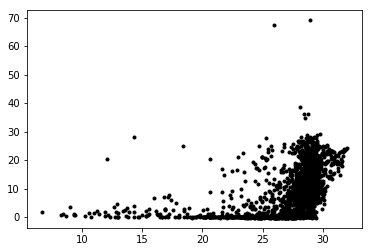

In [7]:
plt.plot(df1['SA'],df1['NO23'],'k.')

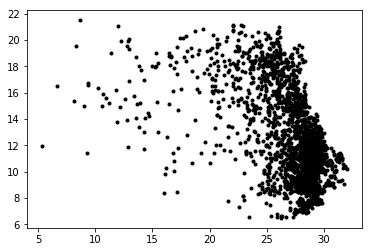

In [8]:
plt.plot(df1['SA'],df1['CT'],'k.')

In [9]:
df1.loc[(~np.isnan(df1.SA)),['SA']].count()

SA    2691
dtype: int64

In [10]:
df1.loc[(~np.isnan(df1.SA))&(np.isnan(df1.NO23)),['SA']].count()

SA    368
dtype: int64

In [11]:
df1.loc[(np.isnan(df1.SA))&(~np.isnan(df1.NO23)),['NO23']].count()

NO23    677
dtype: int64

In [12]:
df1.loc[~np.isnan(df1['CT']),['CT']].count()

CT    2690
dtype: int64

In [13]:
df1.loc[(~np.isnan(df1['CT']))&(np.isnan(df1.NO23)),['CT']].count()

CT    368
dtype: int64

In [14]:
df1.loc[(np.isnan(df1['CT']))&(~np.isnan(df1.NO23)),['NO23']].count()

NO23    678
dtype: int64

In [15]:
df1.loc[(~np.isnan(df1.NO23)),['NO23']].count()

NO23    3000
dtype: int64

In [16]:
print('% of N values without S:')
print(df1.loc[(np.isnan(df1.SA))&(~np.isnan(df1.NO23)),['NO23']].count().values/df1.loc[(~np.isnan(df1.NO23)),['NO23']].count().values*100)

% of N values without S:
[22.56666667]


In [17]:
# use only matched locs. 
df2=df1.loc[(df1.NO23>=0)|(df1.Si>=0)]

In [18]:
dataPSFPhys=et.matchData(df2,filemap, fdict, start_date, end_date, namfmt, PATH, flen)
dataPSF=dataPSFPhys

In [19]:
def rotmap(lon,lat,lon0,lat0,phi):
    # rotate around point (pick one near center of domain)
    # phi in degrees
    # first scale lats to match and center around lat0,lon0:
    lon1=(lon-lon0)*np.cos(lat0*np.pi/180)
    lat1=lat-lat0
    # now rotate:
    lon2=lon1*np.cos(phi*np.pi/180)-lat1*np.sin(phi*np.pi/180)
    lat2=lon1*np.sin(phi*np.pi/180)+lat1*np.cos(phi*np.pi/180)
    return lon2,lat2

In [20]:
cm1=plt.get_cmap('PuBuGn')
#cm1=cmo.cm.matter
theta=-30
lon0=-123.9
lat0=49.3
with nc.Dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/bathymetry_201702.nc') as bathy:
    bathylon=np.copy(bathy.variables['nav_lon'][:,:])
    bathylat=np.copy(bathy.variables['nav_lat'][:,:])
    bathyZ=np.copy(bathy.variables['Bathymetry'][:,:])
blon,blat=rotmap(bathylon,bathylat,lon0,lat0,theta)

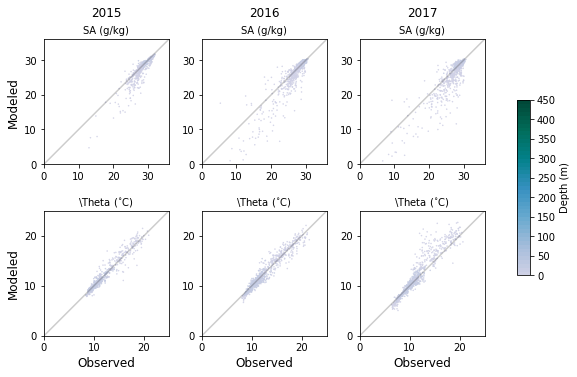

In [21]:
fig = plt.figure(figsize = (7.5,4.5))
gs1=gridspec.GridSpec(2,4,left=.08,right=.98,bottom=.015,top=.94,
                      wspace=.34,hspace=.34,height_ratios=[1,1],width_ratios=[1,1,1,.1])
ax2015N=fig.add_subplot(gs1[0,0])
ax2016N = fig.add_subplot(gs1[0,1])
ax2017N = fig.add_subplot(gs1[0,2])
ax2015Si= fig.add_subplot(gs1[1,0])
ax2016Si= fig.add_subplot(gs1[1,1])
ax2017Si= fig.add_subplot(gs1[1,2])
gscb=gridspec.GridSpecFromSubplotSpec(5,1,subplot_spec=gs1[:,3])
axcb = fig.add_subplot(gscb[1:-1])

for ax in (ax2015N,ax2016N,ax2017N):
    ax.plot((0,36),(0,36),'k-',alpha=.2)
for ax in (ax2015Si,ax2016Si,ax2017Si):
    ax.plot((0,25),(0,25),'k-',alpha=.2)

vm0=-150
args={'marker':'.','s':1,}
dataPSF2015=dataPSF.loc[(dataPSF.dtUTC>=dt.datetime(2015,1,1))&(dataPSF.dtUTC<dt.datetime(2016,1,1))]
ps=et.varvarScatter(ax2015N,dataPSF2015,'AbsSal','mod_vosaline','Z',vmin=vm0,vmax=450,cm=cm1,args=args)
dataPSF2016=dataPSF.loc[(dataPSF.dtUTC>=dt.datetime(2016,1,1))&(dataPSF.dtUTC<dt.datetime(2017,1,1))]
ps=et.varvarScatter(ax2016N,dataPSF2016,'AbsSal','mod_vosaline','Z',vmin=vm0,vmax=450,cm=cm1,args=args)
dataPSF2017=dataPSF.loc[(dataPSF.dtUTC>=dt.datetime(2017,1,1))&(dataPSF.dtUTC<dt.datetime(2018,1,1))]
ps=et.varvarScatter(ax2017N,dataPSF2017,'AbsSal','mod_vosaline','Z',vmin=vm0,vmax=450,cm=cm1,args=args)
ps=et.varvarScatter(ax2015Si,dataPSF2015,'ConsT','mod_votemper','Z',vmin=vm0,vmax=450,cm=cm1,args=args)
ps=et.varvarScatter(ax2016Si,dataPSF2016,'ConsT','mod_votemper','Z',vmin=vm0,vmax=450,cm=cm1,args=args)
ps=et.varvarScatter(ax2017Si,dataPSF2017,'ConsT','mod_votemper','Z',vmin=vm0,vmax=450,cm=cm1,args=args)

cb=fig.colorbar(ps,cax=axcb,boundaries=np.linspace(0,450,46))
cb.set_label('Depth (m)')

ntick=np.arange(0,36,10)
ntickl=[str(i) for i in ntick]
for ax in (ax2015N,ax2016N,ax2017N):
    ax.set_xlim((0,36))
    ax.set_ylim((0,36))
    ax.set_xticks(ntick)
    ax.set_xticklabels(ntickl)
    ax.set_yticks(ntick)
    ax.set_yticklabels(ntickl)
    
stick=np.arange(0,25,10)
stickl=[str(i) for i in stick]
for ax in (ax2015Si,ax2016Si,ax2017Si):
    ax.set_xlim((0,25))
    ax.set_ylim((0,25))
    ax.set_xticks(stick)
    ax.set_xticklabels(stickl)
    ax.set_yticks(stick)
    ax.set_yticklabels(stickl)
    
for ax in (ax2015N,ax2016N,ax2017N,ax2015Si,ax2016Si,ax2017Si):
    ax.set_aspect(1, adjustable='box')
    #ax.set_xlabel('Observed')
    
ax2015N.set_ylabel('Modeled',fontsize=12)
ax2015Si.set_ylabel('Modeled',fontsize=12)
ax2015Si.set_ylabel('Modeled',fontsize=12)
ax2015Si.set_xlabel('Observed',fontsize=12)
ax2016Si.set_xlabel('Observed',fontsize=12)
ax2017Si.set_xlabel('Observed',fontsize=12)

ax2015N.annotate('2015',xy=[.5,1.18],xycoords='axes fraction',ha='center',fontsize=12)
ax2016N.annotate('2016',xy=[.5,1.18],xycoords='axes fraction',ha='center',fontsize=12)
ax2017N.annotate('2017',xy=[.5,1.18],xycoords='axes fraction',ha='center',fontsize=12)
ax2015N.set_title('SA (g/kg)')
ax2016N.set_title('SA (g/kg)')
ax2017N.set_title('SA (g/kg)')
ax2015Si.set_title('\Theta ($^{\circ}$C)')
ax2016Si.set_title('\Theta ($^{\circ}$C)')
ax2017Si.set_title('\Theta ($^{\circ}$C)')


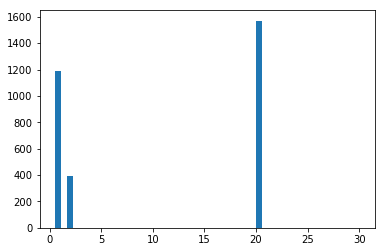

In [22]:
plt.hist(dataPSF.Z,50);

In [23]:
import pickle
pickle.dump(dataPSFPhys,open('/data/eolson/MEOPAR/SS36runs/calcFiles/evalMatches/dataPSFPhys.pkl','wb'))